In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

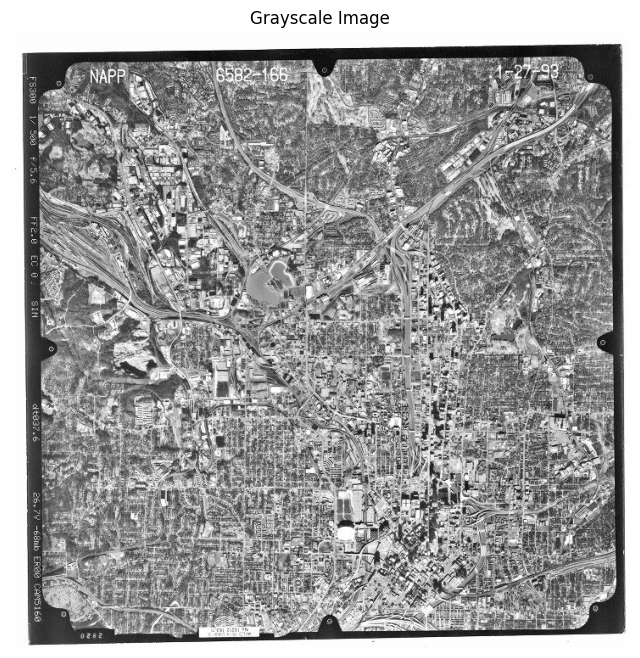

In [35]:
#Grayscaling Aerial Image
image_path = "large.jpg"
img = cv2.imread(image_path)

#Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 8))
plt.title("Grayscale Image")
plt.imshow(gray, cmap="gray")
plt.axis("off")
plt.show()

In [36]:
gray.shape

(726, 731)

In [37]:
#Improving contrast of image incase areas are too dark or too bright
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(gray)

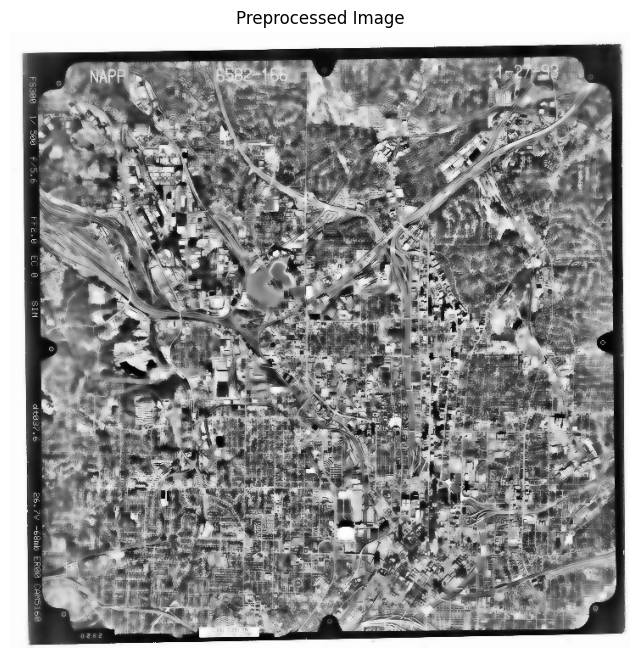

In [38]:
#Used bilateralFilter to smooth image while preserving sharp edges and boundaries
blur = cv2.bilateralFilter(enhanced, 9, 75, 75)

plt.figure(figsize=(8,8))
plt.title("Preprocessed Image")
plt.imshow(blur, cmap="gray")
plt.axis("off")
plt.show()

In [39]:
blur.shape

(726, 731)

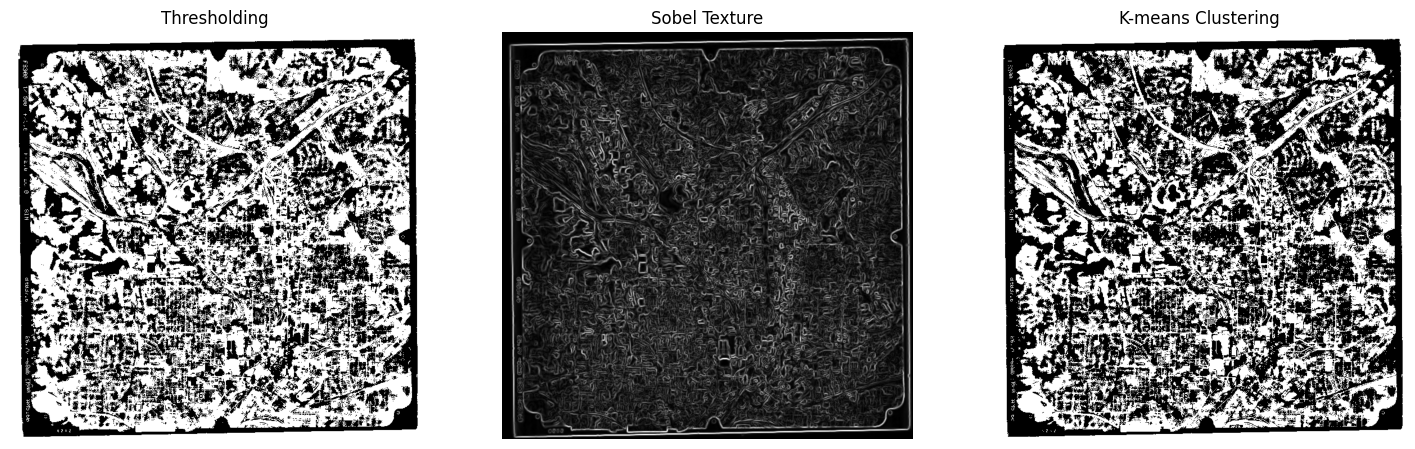

In [40]:
#Method 1: Thresholding
_, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)

#Method 2: Edge/Texture (Sobel Edge Detection)
sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=5)
edges = cv2.magnitude(sobelx, sobely)
edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

#Method 3: Clustering (K-Means on pixel intensity)
Z = blur.reshape((-1,1))
Z = np.float32(Z)
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
labels = kmeans.fit_predict(Z)
clustered = labels.reshape(blur.shape)

#Visualize results
fig, axs = plt.subplots(1,3, figsize=(18,6))
axs[0].imshow(thresh, cmap="gray"); axs[0].set_title("Thresholding"); axs[0].axis("off")
axs[1].imshow(edges, cmap="gray"); axs[1].set_title("Sobel Texture"); axs[1].axis("off")
axs[2].imshow(clustered, cmap="gray"); axs[2].set_title("K-means Clustering"); axs[2].axis("off")
plt.show()

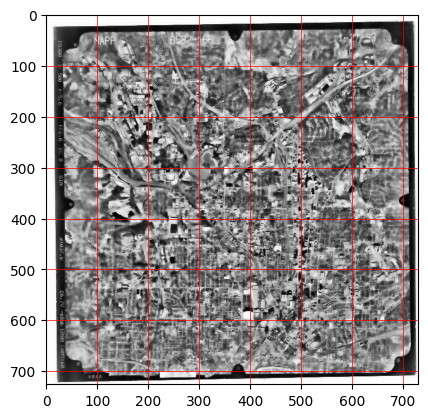

In [41]:
plt.imshow(blur, cmap="gray")
plt.grid(True, color="red", linewidth=0.5)  # overlay a grid
plt.show()

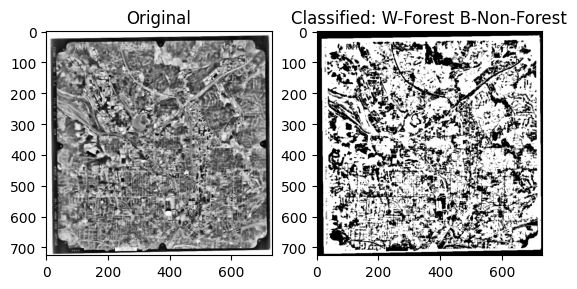

In [15]:
h, w = blur.shape
pixels = blur.reshape(-1, 1)

#Define patches for each class
#Format: (row_start, row_end, col_start, col_end)
patches = {
    1: [ (100,200, 300,400), (200,300, 500,600), (400,450, 530,600) ],  # class 1: Forest
    0: [ (500,600, 300,400), (500,600, 500,600) ]                   # class 0: Non-Forest
}

#Extract samples from patches
X_patches, y_patches = [], []
for label, regions in patches.items():
    for (r1, r2, c1, c2) in regions:
        patch_pixels = blur[r1:r2, c1:c2].reshape(-1, 1)
        X_patches.append(patch_pixels)
        y_patches.append(np.full(patch_pixels.shape[0], label))

X = np.vstack(X_patches)
y = np.hstack(y_patches)

#Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

#Predict for all pixels
preds = clf.predict(pixels)
classified = preds.reshape(h, w)

plt.subplot(1,2,1)
plt.imshow(blur, cmap="gray")
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(classified, cmap="gray")
plt.title("Classified: W-Forest B-Non-Forest")

plt.show()

Based on the provided code, I modified the approach to manually select and label pixels from the grid plot. I then used this data to train a Logistic Regression model and visualize the results.

In [19]:
#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Train the classifier on the training data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

#Make predictions on the test data
y_pred = clf.predict(X_test)

#Generate and print the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.59      0.36      0.45      5977
           1       0.59      0.78      0.68      7073

    accuracy                           0.59     13050
   macro avg       0.59      0.57      0.56     13050
weighted avg       0.59      0.59      0.57     13050



From my initial image, I plotted it on a grid and manually took samples of Forest and Non-Forest using the pixel coordinates. I then used these sample pixels to train and run a Logistic Regression Model to classify the pixels as either Forest: White Pixels or Non-Forest: Black pixels and then plotted my results.